<!--HEADER-->
[*Notas sobre modelagem da epidemia de Covid-19*](https://github.com/rmsrosa/modcovid19) / [*IM-UFRJ*](https://www.im.ufrj.br).

<!--BADGES-->
<a href="../slides/07.00.Aula-Modelos_individuos_estruturados.slides.html"><img align="left" src="https://img.shields.io/badge/local-slides-darkgreen" alt="localslides" title="Local Slides"></a>
&nbsp;

<!--NAVIGATOR-->
[<- Modelos baseados em indivíduos e o relatório do Imperial Colege](06.00.Aula-Modelos_baseados_em_individuos.ipynb) | [Página Inicial](00.00-Pagina_Inicial.ipynb) | [Modelos individuais estocásticos com múltiplas estruturas de conexão - parte I ->](08.00.Aula-Modelos_individuais_multiplas_estruturas.ipynb)

---


# Modelos indivuais estocásticos estruturados

**Importando bibliotecas e definindo funções a serem usadas abaixo**

In [1]:
import datetime as dt # date and time tools

from collections import namedtuple

from os import path

import numpy as np
from scipy.integrate import solve_ivp
import networkx as nx

import matplotlib.pyplot as plt
import seaborn as sns

import io, base64
from IPython.display import Image, HTML

In [2]:
def show_video(path_to_video, width):
    video = io.open((path_to_video), 'r+b').read()
    encoded = base64.b64encode(video)
    video_data = '''<video width="{0}" alt="test" controls><source src="data:video/mp4;base64,{1}" type="video/mp4" />
                    </video>'''.format(width, encoded.decode('ascii'))
    return HTML(data=video_data)

In [3]:
dt_string = dt.datetime.now().strftime("%d/%b/%Y")
print(f"Atualização mais recente do kernel: {dt_string}")

Atualização mais recente do kernel: 06/May/2020


In [4]:
sns.set_style("darkgrid")

## A importância da estrutura da rede de conexões

- Lembremos da figura a seguir, retirada do livro [Kiss, Miller & Simon (2017)](#Referências), que mostra a importância da estrutura da rede conexões na evolução da epidemia.

- O modelo dele não é individual, mas é um compartimental estruturado estocástico, com muitos compartimentos ($100$ mil nós), que carrega bastante estrutura.

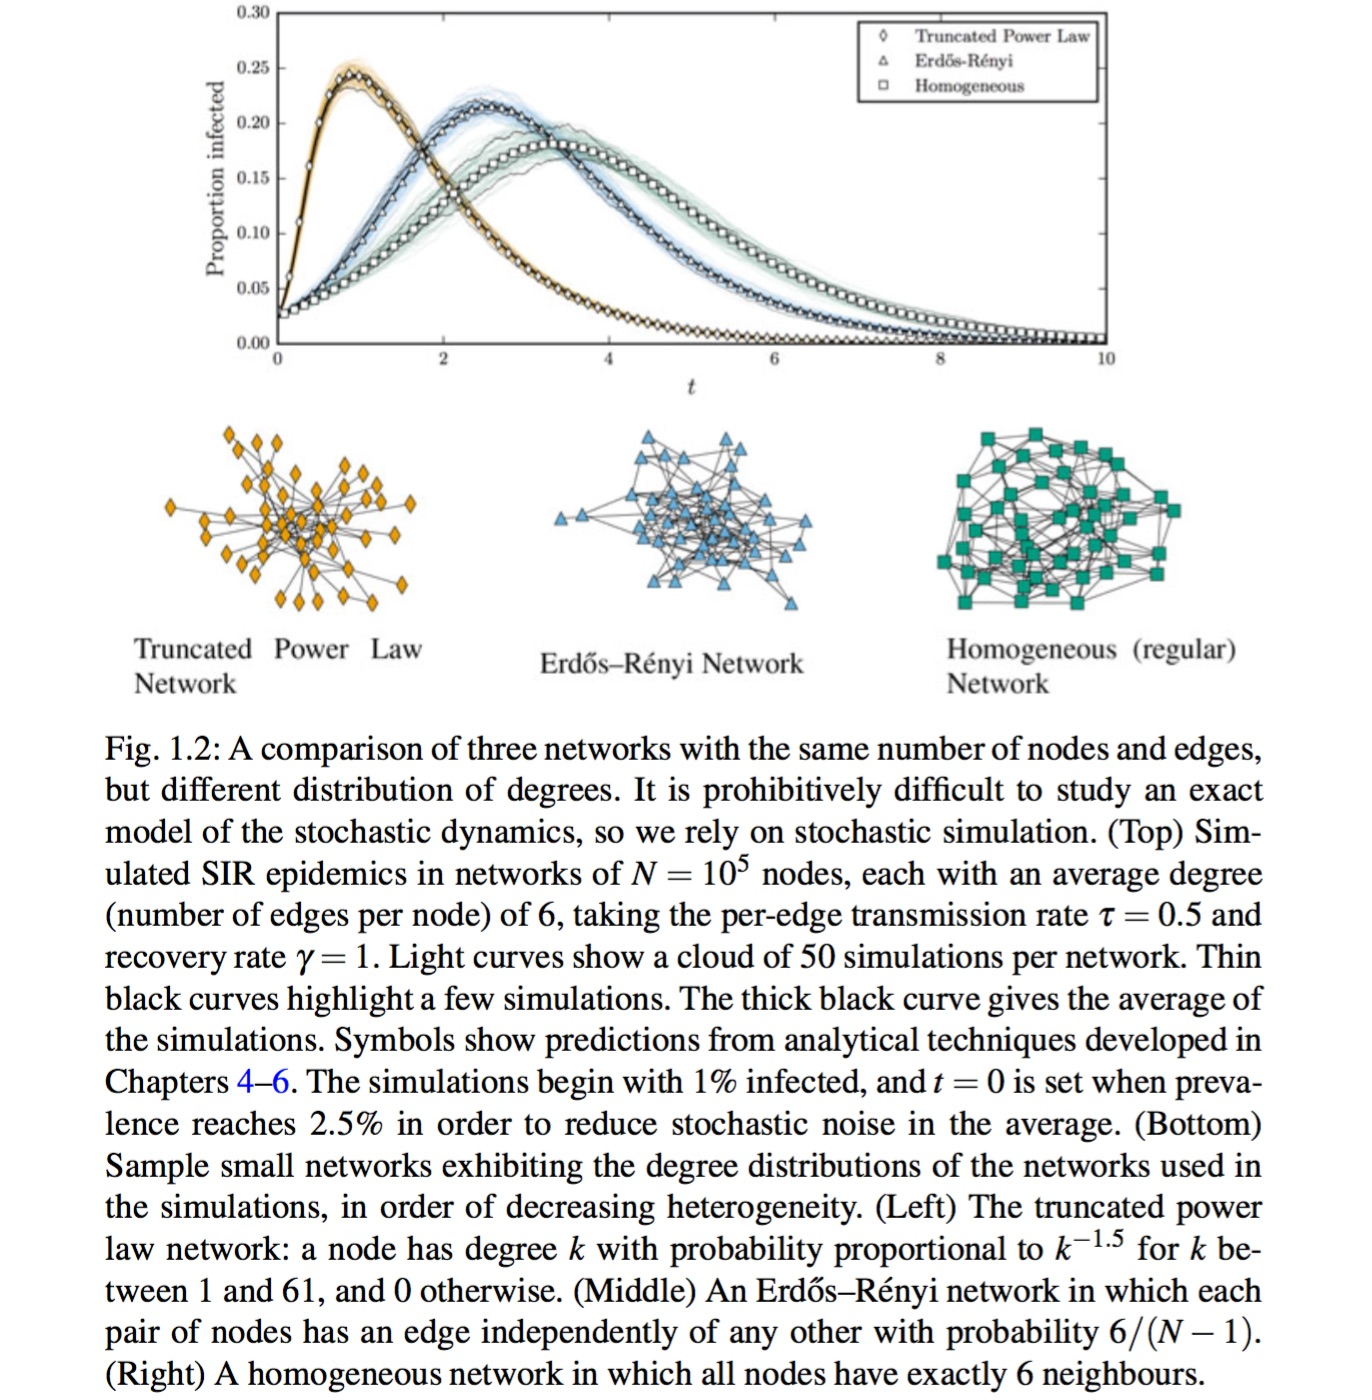

In [5]:
Image(filename=path.join('..', 'input', 'networks', 'SIR_on_different_networks.jpg'), width=800)

### Exemplos de simulações individuais

- A seguir, três vídeos retirado das [informações suplementares](https://www.nature.com/articles/nature04017?draft=collection#Sec14) do artigo de [Ferguson et al. (2005)](#Referência), sobre **estratégias para conter pandemias de influenza na sudeste asiático**. 

- Observem que eles já estavam pensando nesses estratégias!

- Vieram motivadas pela epidemia de SARS que apareceu no final de 2002 e só foi considerada contida em meados de 2003, com vários casos ocorrendo até o iníco de 2004.

- Simulação com **85 milhões de indivíduos**!

- A primeira, **sem estratégia** de contenção da epidemia.

- A segunda, **estratégia mais extensa, bem sucedida**.

- A terceira, **estratégia em apenas um país, mal sucedida**.

Os vídeos originais estão em formato `.mov`, muito mais pesado, e foram transformados em `.mp4` com o commando

```bash
ffmpeg -i 41586_2005_BFnature04017_MOESM3_ESM.mov -vf format=yuv420p -y 41586_2005_BFnature04017_MOESM3_ESM.mp4
```

#### Sem estratégia

- $R_0=1.5$.

- Video mostra 100 dias de evolução.

- Cores:

    - Cinza: densidade de suscetíveis em escala logarítmica
    - Vermelho: áreas infectadas
    - Verde: áreas recuperadas
    - Azul: áreas em tratamento

In [6]:
show_video(path.join('..', 'input', 'networks', '41586_2005_BFnature04017_MOESM2_ESM.mp4'), '50%')

#### Estratégia bem sucedida

- $R_0=1.8$;

- Estratégia implementada na Tailândia e em parte dos países vizinhaça, dentro de um raio de 100km da Tailândia.

- Distanciamento social

- Quarentena de casos detectados

- Profilaxia em um raio de 5km radial de casos dectados

- Fechamento de 90% de escolas e de 50% dos lugares de trabalho, em um raio de 5km.

- Video mostra 300 dias de evolução.

- Cores:

    - Cinza: densidade de suscetíveis em escala logarítmica
    - Vermelho: áreas infectadas
    - Verde: áreas recuperadas
    - Azul: áreas em tratamento

In [7]:
show_video(path.join('..', 'input', 'networks', '41586_2005_BFnature04017_MOESM3_ESM.mp4'), '80%')

#### Estratégia mal-sucedida

- $R_0=1.7$.

- Estratégias implementadas em apenas um país: Tailândia

- Distanciamento social

- Quarentena de casos detectados

- Profilaxia em um raio de 5km radial de casos dectados

- Fechamento de 90% de escolas e 50% de lugares de trabalho no raio de 5km.

- Video mostra 300 dias de evolução.

- Cores:

    - Cinza: densidade de suscetíveis em escala logarítmica
    - Vermelho: áreas infectadas
    - Verde: áreas recuperadas
    - Azul: áreas em tratamento

In [8]:
show_video(path.join('..', 'input', 'networks', '41586_2005_BFnature04017_MOESM4_ESM.mp4'), '50%')

## Modelagem

### Parâmetros

Nas modelagens que faremos a seguir:

- População: $300$ indivíduos;

- $\beta= 0.5$ (taxa diária de contágio);

- $\gamma=0.1$ (taxa de recuperação - 10 dias);

- $R_0 = 5$ (número básico de reprodução).

- $I_0 = 8$ (número inicial de infectados);

- $T = 80$ (80 dias de simulação);

Nos exemplos com rede, usamos

- $\kappa = $ número médio de conexões por indivíduo (arestas por vértice);

- $\tau = \beta/\kappa$ (contágio por contato).

In [9]:
num_pop = 300
beta = 0.5
gamma = 0.1
R0 = beta/gamma
I_0 = 8
T = 80
tempos = np.array(range(T+1))
num_sim = 60
print(f'Número básico de reprodução = {R0:.2f}')

Número básico de reprodução = 5.00


### Estado da população

- Temos um **índice** $i=1, \ldots, N$ **para cada indivíduo**.

- O **estado do sistema** todo é representado por um vetor $\mathbf{x} = (x_1, \ldots, x_N)$ de dimensão $N$.

- Cada coordenada $x_i$ do vetor $\mathbf{x}$ representa o **estado do individuo** $i$.

- Cada indivíduo pode estar em um dos possívei estágios: **suscetível**, **infectado** ou **removido**..

- Representamos isso permitindo que $x_i$ assuma três valores, cada um correspondendo a um dos estágios:

    - $x_i=1:$ indivíduo **suscetível**;
    
    - $x_i=2:$ indivíduo **infectado**;
    
    - $x_i=3:$ indivíduo **removido**.
O estado da população é um vetor 


In [10]:
# estado inicial da população
pop_0 = np.ones(num_pop)
infectados_0 = np.random.choice(num_pop, I_0)
pop_0[infectados_0] = 2*np.ones(I_0)
attr_pop_0 = dict([(i, {'estado': int(pop_0[i])}) for i in range(num_pop)])
print(pop_0)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 1.
 1. 1. 1. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 2. 1. 1. 1. 2. 1. 1. 1. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


### Evolução temporal

- **Método $\tau$-leap** *($\tau$-leap method):*

    - Evolução discreta no tempo.
    
    - Múltiplos eventos ocorrendo a cada passo de tempo.

    - Taxas de ocorrência de algum evento se tornam probabilidades da forma

    $$ \mathbb{P}(\textrm{evento}) = 1 - e^{\displaystyle - \textrm{taxa} \,\times \,\textrm{passo de tempo}}.
    $$

    - Isso segue de 
    
    $$ y' = -\alpha y \; \Longrightarrow \;y(t+\delta t) = y(t) e^{-\alpha \delta t} \;\Longrightarrow \;\Delta y = y(t+\delta t) - y(t) = (1 - e^{-\alpha \delta t})y(t).
    $$

- Passos muito grandes diminuem a acurácia do método.

- Passos muito curtos o tornam bastante custoso caso haja um número muito grande de indivíduos.

- Veja [Box 7.3, página 270, de Keeling & Rohani (2007)](#Referências).

- As simulações acima na Tailândia foram com passos de 1/4 de dia, ou 6 horas.

- Vamos usar, inicialmente, passos de um dia apenas.

## Funções de evolução e de análise

Definimos algumas funções para facilitar as simulações.

- `evolucao_SIR`

- `analise_grafo`

- `evolucao_grafo`

In [11]:
def evolucao_SIR(pop_0, beta, gamma, tempos, plot=False):

    SIR_Compartimental = namedtuple('SIR_Compartimental', 
                                 [
                                     'pop_0',
                                     'num_pop',
                                     'beta',
                                     'gamma',
                                     't_instantes',
                                     'S',
                                     'I', 
                                     'R',
                                     'X'
                                 ])        
          
    def diferencial(t, X, N, beta, gamma):
        S, I = X
        dXdt = [- beta*I*S/N, beta*I*S/N - gamma*I]
        return dXdt        
    
    num_pop = sum(pop_0)
    y0 = pop_0[0:2]
    sol = solve_ivp(diferencial, t_span=[tempos[0],tempos[-1]], 
                    y0 = y0, t_eval = tempos,
                    args=(num_pop, beta, gamma))
    
    resultado = SIR_Compartimental(pop_0, num_pop, beta, gamma, tempos,
                                   sol.y[0], sol.y[1], num_pop - sol.y[0] - sol.y[1], sol)
    return resultado

In [12]:
def analise_grafo(G, info=True, node_size=0, pos=None, hist=False):

    num_vertices = G.number_of_nodes()
    num_arestas = G.number_of_edges()
    num_arestas_por_vertice = [j for i,j in G.degree]
    num_medio_conexoes = 2*num_arestas/num_vertices

    if info:
        print(f'Número de arestas: {num_arestas}')
        print(f'Número de vértices: {num_vertices}')
        print(f'Número médio de conexões por indivíduo: {num_medio_conexoes:.1f}')

    if node_size:
        color = ['tab:blue', 'tab:red', 'tab:green']
        pop_estado = nx.get_node_attributes(G,'estado')
        color_map = [color[pop_estado[j]-1] for j in range(num_vertices)]
        plt.figure(figsize=(10,6))
        if pos:
            nx.draw(G, pos, node_size=node_size, node_color=color_map, alpha=0.5)
        else:
            nx.draw(G, node_size=node_size, node_color=color_map, alpha=0.5)
        plt.title('Rede de indivíduos e de suas conexões', fontsize=16)
        plt.show()

    if hist:
        plt.figure(figsize=(10,6))
        plt.hist(num_arestas_por_vertice, 50, facecolor='g', alpha=0.75)
        plt.xlabel('num. arestas', fontsize=14)
        plt.ylabel('num. vertices', fontsize=14)
        plt.title('Histograma do número vértices por número de arestas', fontsize=16)
        plt.show()
    return num_medio_conexoes

In [13]:
def evolucao_grafo_estruturado(pop_0, mu, gamma, G, tempos, num_sim, show=''):
    """Evolução temporal da epidemia em um grafo estruturado.


    Entrada:
        pop_0: numpy.array
            state of the population, with 
                1: suscetível
                2: infectado
                3: recuperado ou removido

        mu: float
            probabilidade de contágio por contato

        gamma: float
            taxa de recuperação por unidade de tempo

        G: numpy.array
            grafo de conexões

        tempos: numpy.array
            instantes de tempo

        num_sim: int
            número de simulações

        show: str
            indica se é para exibir um gráfico e de que tipo:
                - 'nuvem': exibe uma nuvem com todas as simulações e o valor médio em destaque
                - 'sd': exibe o valor médio com um intervalo de confiança dado pelo desvio padrão
                - 'media': exibe apenas o valor médio
                - '': não exibe gráfico algum.

    Saída
        X: class.SIR_Individual
            Uma instância da classe `SIR_Individual` com os seguintes atributos:
                pop_0:
                num_pop:
                mu:
                gamma:
                tempos:
                num_sim:
                S_media:
                I_media: 
                R_media:
                I_sigma:
                R_sigma:
                S_sigma:
    """

    def passo_grafo_estruturado(num_pop, populacao, A_adj, prob_infeccao, prob_recuperacao):
        
        # gera uma matriz cheia aleatória (números em [0.0,1.0))
        A_random = np.random.rand(num_pop, num_pop)
        
        # filtra de acordo com as conexões
        A_graph_random = np.multiply(A_adj, A_random)
        
        # copia a população (acho que é desnecessário)
        pop_aux = np.copy(populacao)
        
        # separa os suscetíveis, criando um vetor de 1's e 0's, se for, ou não, suscetível
        pop_suscetiveis = np.select([pop_aux==1], [pop_aux])
        
        # separa os infectados, criando um vetor de 1's e 0's, se for, ou não, infectável
        pop_infectados = np.select([pop_aux==2], [pop_aux])/2
        
        # cria uma matriz de risco, mantendo apenas as conexões que envolvem um infectado
        A_risco = np.multiply(np.tile(pop_infectados, (num_pop, 1)), A_graph_random)
        
        # cria matriz de contatos entre um suscetível e um infectado
        A_contatos = np.multiply(np.tile(pop_suscetiveis, (num_pop, 1)).transpose(), A_risco)
        
        # cria uma matriz de 1's e 0's, indicando se houve, ou não, contágio
        A_infectados = np.select([A_contatos > 1-prob_infeccao], [np.ones([num_pop, num_pop])])

        # obtém novos infectados
        pop_novos_infectados = np.select([np.sum(A_infectados, axis=1)>0], [np.ones(num_pop)])
        
        # filtra matriz aleatória com a diagonal
        pop_recuperando = pop_infectados @ np.multiply(np.eye(num_pop), A_random)
        
        # obtém novos recuperados
        pop_novos_recuperados = np.select([pop_recuperando > 1-prob_recuperacao], [np.ones(num_pop)])
        
        # atualiza população adicionando um aos que avançaram de estágio
        populacao_nova = pop_aux + pop_novos_infectados + pop_novos_recuperados

        # Observe que cada elemento da matriz aleatória é usado apenas uma vez, garantindo
        # a independência desses eventos aleatórios (tanto quanto se leve em consideração
        # que os números gerados são pseudo-aleatórios)

        return populacao_nova

    
    # confere se escolha para `show` é válida
    if show:
        assert(show in ('nuvem', 'sd', 'media')), 'Valor inválido para argumento `show`.'

    # atributos de saída
    SIR_Individual = namedtuple('SIR_Individual', 
                                [
                                    'pop_0',
                                    'num_pop',
                                    'mu',
                                    'gamma',
                                    'tempos',
                                    'num_sim',
                                    'S_media',
                                    'I_media', 
                                    'R_media',
                                    'S_sigma',
                                    'I_sigma', 
                                    'R_sigma'
                                ])
    
    # número de indivíduos da população
    num_pop = len(pop_0)
    I_0 = np.count_nonzero(pop_0==2)        

    # número de instantes no tempo e passos de tempo 
    num_t = len(tempos)
    passos_de_tempo = tempos[1:] - tempos[:-1]

    # inicializa variáveis para o cálculo da média
    S_media = np.zeros(num_t)
    I_media = np.zeros(num_t)
    R_media = np.zeros(num_t)

    # inicializa variáveis para o cálculo do desvio padrão
    S_sigma = np.zeros(num_t)
    I_sigma = np.zeros(num_t)
    R_sigma = np.zeros(num_t)
    
    # obtém matriz de adjacências
    A_adj = nx.to_numpy_matrix(G)

    # prepara gráfico se necessário
    if show in ('nuvem', 'sd', 'media'):    
        # inicializa figura e define eixo vertical
        plt.figure(figsize=(12,6))
        plt.ylim(0, num_pop)
        plt.xlim(tempos[0], tempos[-1])
    
    if show == 'nuvem':
        # alpha para a nuvem de gráficos das diversas simulaçõe
        alpha = min(0.2, 5/num_sim)    

    # simulações
    for j in range(num_sim):

        # inicializa população de cada simulação
        populacao = np.copy(pop_0)
        S = np.array([num_pop - I_0])
        I = np.array([I_0])
        R = np.array([0])
     
        
        # evolui o dia e armazena as novas contagens
        for dt in passos_de_tempo:

            # calcula probabilidades
            prob_infeccao = 1 - np.exp(-mu*dt)
            prob_recuperacao = 1 - np.exp(-gamma*dt)

            populacao = passo_grafo_estruturado(num_pop, populacao, A_adj,
                                                prob_infeccao, prob_recuperacao)
            S = np.hstack([S, np.count_nonzero(populacao==1)])
            I = np.hstack([I, np.count_nonzero(populacao==2)])
            R = np.hstack([R, np.count_nonzero(populacao==3)])
            
        # adiciona as contagens dessa simulação para o cálculo final da média
        S_media += S
        I_media += I
        R_media += R

        # adiciona as contagens dessa simulação para o cálculo final do desvio padrão
        S_sigma += S ** 2
        I_sigma += I ** 2
        R_sigma += R ** 2

        if show == 'nuvem':
            # exibe os gráficos dos dados de cada simulação
            plt.plot(tempos, S, '-', color='tab:green', alpha=alpha)
            plt.plot(tempos, I, color='tab:red', alpha=alpha)
            plt.plot(tempos, R, '-', color='tab:blue', alpha=alpha)
            plt.plot(tempos, num_pop - S, '-', color='tab:gray', alpha=alpha)

    # divide pelo número de evoluções para obter a média
    S_media /= num_sim
    I_media /= num_sim
    R_media /= num_sim

    # ajusta o calcula do desvio padrão
    S_sigma = ( S_sigma / num_sim - S_media**2 )**.5
    I_sigma = ( I_sigma / num_sim - I_media**2 )**.5
    R_sigma = ( R_sigma / num_sim - R_media**2 )**.5

    # exibe os gráficos das médias
    if show in ('nuvem', 'sd', 'media'):
        plt.plot(tempos, S_media, '-', color='tab:green', label='suscetíveis')
        plt.plot(tempos, I_media, '-', color='tab:red', label='infectados')
        plt.plot(tempos, R_media, '-', color='tab:blue', label='recuperados')
        plt.plot(tempos, num_pop - S_media, '-', color='tab:gray', label='inf.+ rec.')
        
    if show == 'sd':
        plt.fill_between(tempos, S_media - S_sigma, S_media + S_sigma, facecolor='tab:green', alpha = 0.2)
        plt.fill_between(tempos, I_media - I_sigma, I_media + I_sigma, facecolor='tab:red', alpha = 0.2)
        plt.fill_between(tempos, R_media - R_sigma, R_media + R_sigma, facecolor='tab:blue', alpha = 0.2)
        plt.fill_between(tempos, num_pop - S_media - S_sigma, num_pop - S_media + S_sigma, facecolor='tab:gray', alpha = 0.2)

        
    if show == 'nuvem':
        plt.title('Evolução do conjunto de simulações e da média', fontsize=16)
    elif show == 'sd':
        plt.title('Evolução da média, com o desvio padrão', fontsize=16)
    elif show == 'media':
        plt.title('Evolução da média das simulações', fontsize=16)

        
    # informações para o gráfico
    if show in ('nuvem', 'sd', 'media'):
        plt.xlabel('tempo', fontsize=14)
        plt.ylabel('número de indivíduos', fontsize=14)
        plt.legend(fontsize=12)
        plt.show() 

    resultado = SIR_Individual(
        pop_0,
        num_pop,
        mu,
        gamma,
        tempos,
        num_sim,
        S_media,
        I_media, 
        R_media,
        I_sigma,
        R_sigma,
        S_sigma
    )

    return resultado

## SIR Compartimental

Começamos com a simulação SIR Compartimental, para servir de comparação com as simulações indi

In [14]:
X = evolucao_SIR(pop_0 = [num_pop-I_0, I_0, 0], beta=beta, gamma=gamma, tempos = tempos)

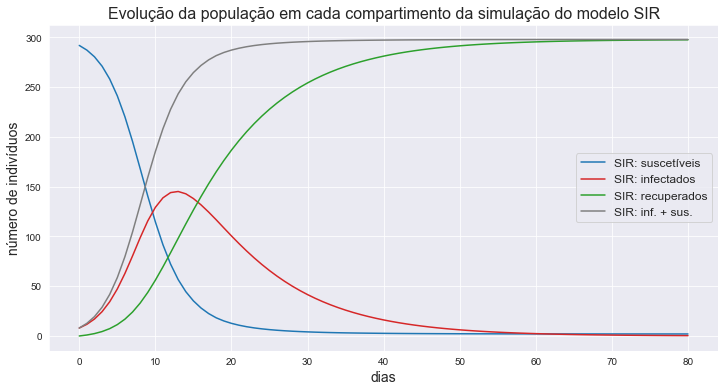

In [15]:
plt.figure(figsize=(12,6))

# exibe os gráficos das médias
plt.plot(tempos, X.S, 'tab:blue', label='SIR: suscetíveis')
plt.plot(tempos, X.I, 'tab:red', label='SIR: infectados')
plt.plot(tempos, X.R, 'tab:green', label='SIR: recuperados')
plt.plot(tempos, X.I + X.R, 'tab:gray', label='SIR: inf. + sus.')

# informações para o gráfico
plt.xlabel('dias', fontsize=14)
plt.ylabel('número de indivíduos', fontsize=14)
plt.title('Evolução da população em cada compartimento da simulação do modelo SIR', fontsize=16)
plt.legend(loc='best', fontsize=12)
plt.show() 

## Redes

- Agora vamos fazer simulações em algumas redes.

- Neste primeiro momento, consideramos apenas redes fixas e com contatos uniformes.

- Posteriormente, devemos incluir outras conexões e pesos
    - redes para as conexões frequentes
        - rede estruturada fixa com arestas com pesos determinados pela relação entre os indivíduos
        - Exemplos:
            - familiares, com um peso maior;
            - trabalho e escola;
            - amigos;
    - redes para as conexões aleatórias
        - Exemplos:
            - praças, shoppings e parques
            - em meios de transporte;
        - rede completa geométrica, com pesos dependendo da distância;

- Para a criação das redes, usaremos funções descritas em [NetworkX 2.4: Graph Generators](https://networkx.github.io/documentation/stable/reference/generators.html) para gerar alguns grafos **sintéticos**.

In [16]:
# Checando versão no NetworkX
nx.__version__

'2.4'

## Simulação em uma rede regular

- Começamos com uma rede regular.

- Cada indivíduo (vértice) tem o mesmo número de conexões (arestas).

- Usamos a função [nx.gnp_random_graph](https://networkx.github.io/documentation/stable/reference/generated/networkx.generators.random_graphs.random_regular_graph.html#networkx.generators.random_graphs.random_regular_graph).

### Criando a rede e analisando seus dados

Número de arestas: 44850
Número de vértices: 300
Número médio de conexões por indivíduo: 299.0


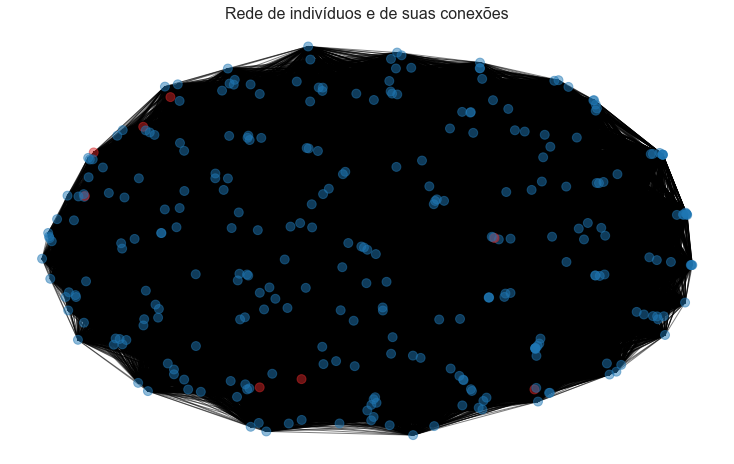

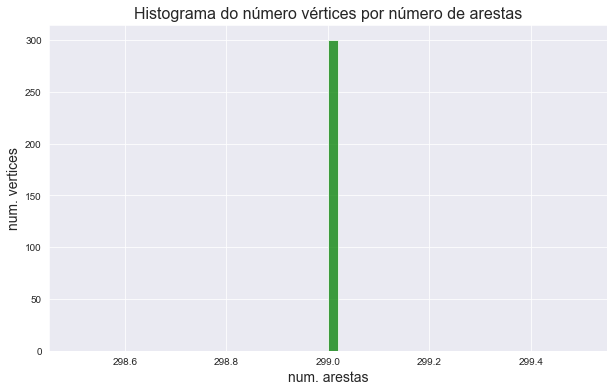

In [17]:
G_r = nx.random_regular_graph(d=num_pop-1, n=num_pop, seed=12)
nx.set_node_attributes(G_r, attr_pop_0)

num_medio_conexoes_r = analise_grafo(G_r, info=True, node_size=80, pos=None, hist=True)

### Simulação

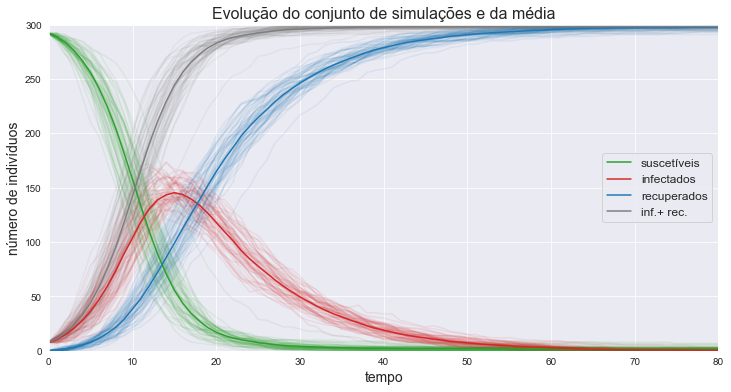

CPU times: user 25.6 s, sys: 253 ms, total: 25.9 s
Wall time: 13.5 s


In [18]:
%%time
X_r = evolucao_grafo_estruturado(pop_0, beta/num_medio_conexoes_r, gamma, G_r, tempos,
                                 num_sim, show='nuvem')

### Comparação com o SIR compartimental

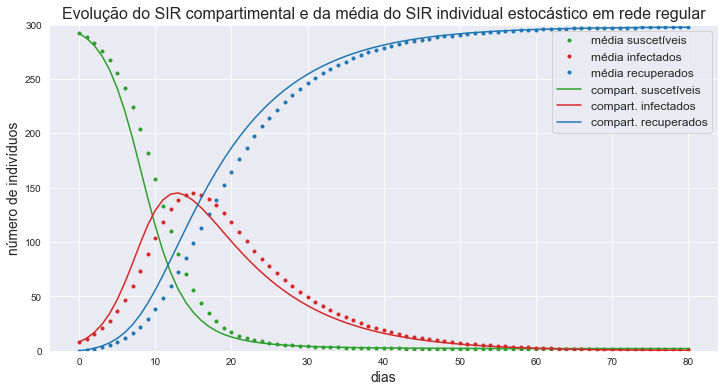

In [19]:
plt.figure(figsize=(12,6))
plt.ylim(0, num_pop)

# exibe os gráficos das médias
plt.plot(tempos, X_r.S_media, '.', color='tab:green', label='média suscetíveis')
plt.plot(tempos, X_r.I_media, '.', color='tab:red', label='média infectados')
plt.plot(tempos, X_r.R_media, '.', color='tab:blue', label='média recuperados')

plt.plot(tempos, X.S, 'tab:green', label='compart. suscetíveis')
plt.plot(tempos, X.I, 'tab:red', label='compart. infectados')
plt.plot(tempos, X.R, 'tab:blue', label='compart. recuperados')

# informações para o gráfico
plt.xlabel('dias', fontsize=14)
plt.ylabel('número de indivíduos', fontsize=14)
plt.title(f'Evolução do SIR compartimental e da média do SIR individual estocástico em rede regular', fontsize=16)
plt.legend(loc='best', fontsize=12)
plt.show() 

## Simulação em uma rede do tipo Ërdos-Renyi

- Rede aleatória com a propriedade do número de conexões de cada indivíduo (arestas para cada vértice) ser próximo do número médio.

- A função `erdos_renyi_graph()` do módulo `networkx` cria aleatoriamente uma rede desse tipo.

- Recebe como argumentos o número de vértices e uma dada densidade média do número de arestas.

- A função `to_numpy_matrix` do `networkx` retorna a matriz de adjacências, com as conexões (arestas) entre os indivíduos (vértices).

### Criando a rede e analisando seus dados

In [20]:
G_er = nx.erdos_renyi_graph(num_pop, 6/num_pop, seed=12)
nx.set_node_attributes(G_er, attr_pop_0)

Número de arestas: 821
Número de vértices: 300
Número médio de conexões por indivíduo: 5.5


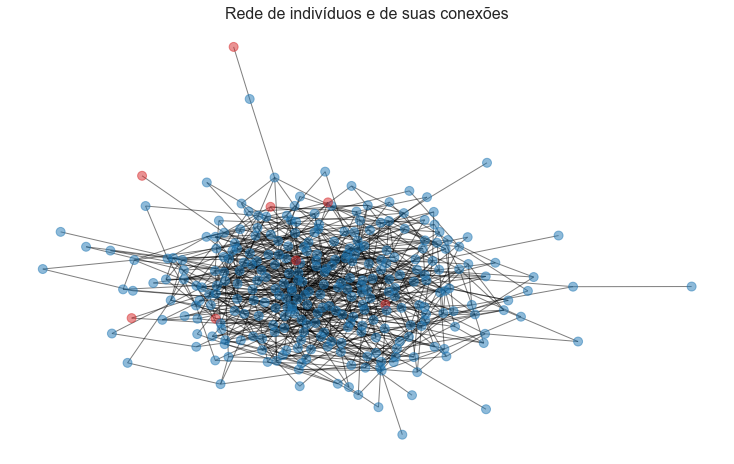

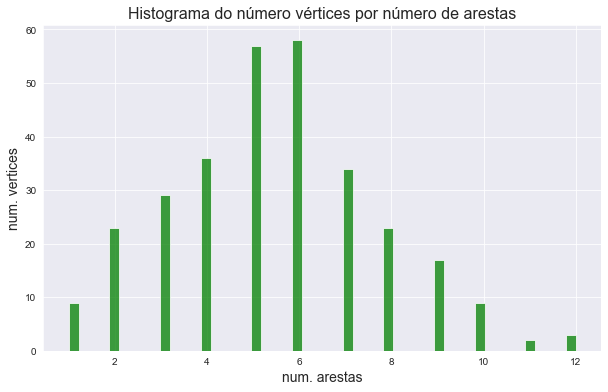

In [21]:
num_medio_conexoes_er = analise_grafo(G_er, info=True, node_size=80, pos=None, hist=True)

### Simulação

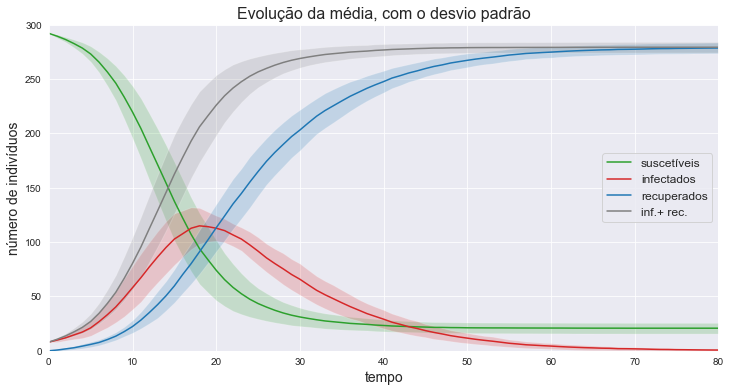

CPU times: user 26.2 s, sys: 883 ms, total: 27.1 s
Wall time: 13.9 s


In [22]:
%%time 
X_er = evolucao_grafo_estruturado(pop_0, beta/num_medio_conexoes_er, gamma, G_er, tempos,
                                  num_sim, show='sd')

### Comparação com o SIR compartimental

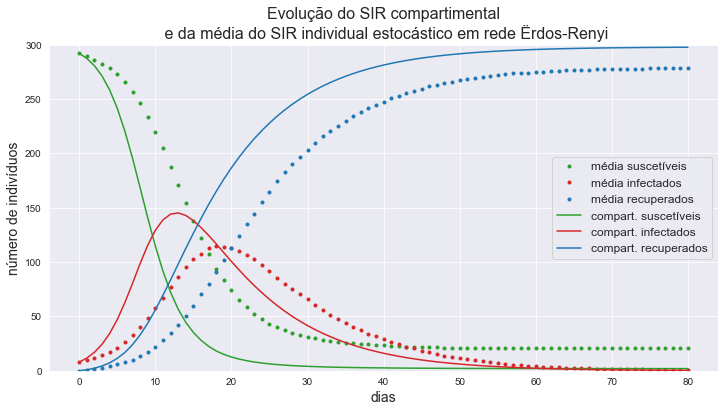

In [23]:
plt.figure(figsize=(12,6))
plt.ylim(0, num_pop)

# exibe os gráficos das médias
plt.plot(tempos, X_er.S_media, '.', color='tab:green', label='média suscetíveis')
plt.plot(tempos, X_er.I_media, '.', color='tab:red', label='média infectados')
plt.plot(tempos, X_er.R_media, '.', color='tab:blue', label='média recuperados')

plt.plot(tempos, X.S, 'tab:green', label='compart. suscetíveis')
plt.plot(tempos, X.I, 'tab:red', label='compart. infectados')
plt.plot(tempos, X.R, 'tab:blue', label='compart. recuperados')

# informações para o gráfico
plt.xlabel('dias', fontsize=14)
plt.ylabel('número de indivíduos', fontsize=14)
plt.title('Evolução do SIR compartimental\n e da média do SIR individual estocástico em rede Ërdos-Renyi', fontsize=16)
plt.legend(loc='best', fontsize=12)
plt.show() 

## Simulação com um grafo Barabasi-Albert

- Possui indivíduos com muitas conexões.


Número de arestas: 1764
Número de vértices: 300
Número médio de conexões por indivíduo: 11.8


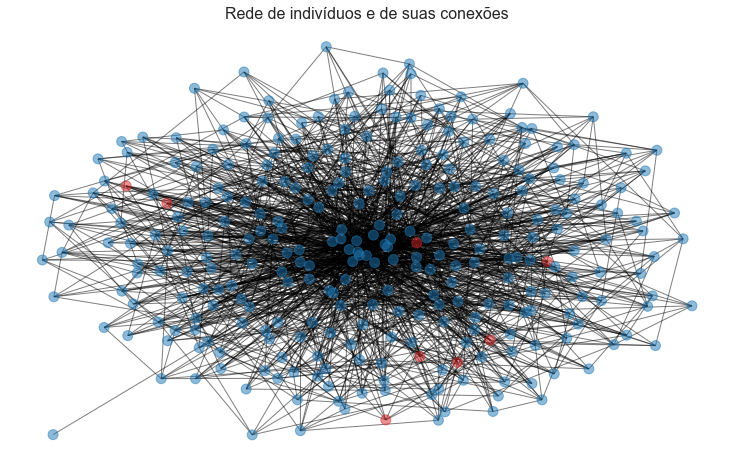

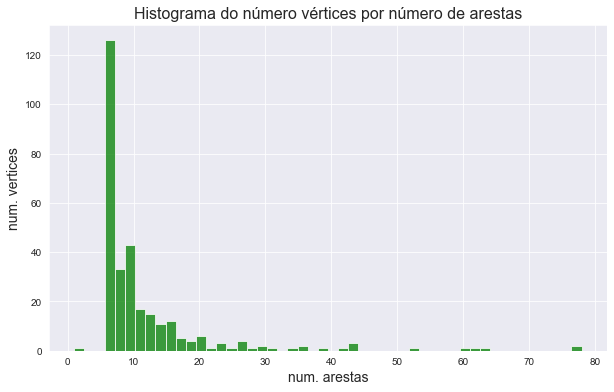

In [24]:
G_ba = nx.barabasi_albert_graph(num_pop, 6, seed=1)
nx.set_node_attributes(G_ba, attr_pop_0)
num_medio_conexoes_ba = analise_grafo(G_ba, info=True, node_size=100, pos=None, hist=True)

### Simulação

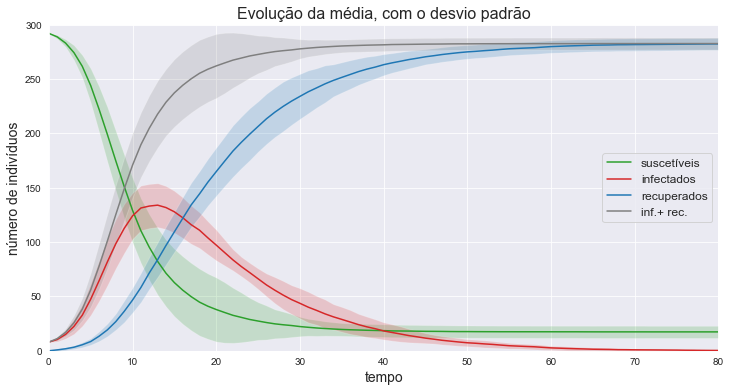

In [25]:
X_ba = evolucao_grafo_estruturado(pop_0, beta/num_medio_conexoes_ba, gamma,G_ba, tempos,
                                  num_sim, show='sd')

### Comparação com o SIR Compartimental

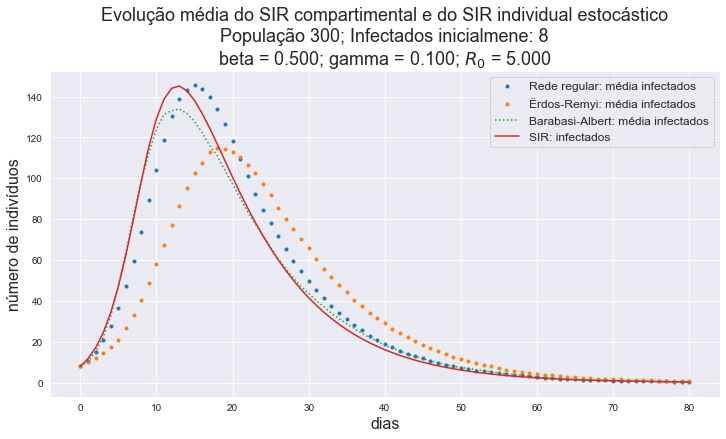

In [26]:
plt.figure(figsize=(12,6))

# exibe os gráficos das médias
plt.plot(tempos, X_r.I_media, '.', label='Rede regular: média infectados')
plt.plot(tempos, X_er.I_media, '.', label='Ërdos-Remyi: média infectados')
plt.plot(tempos, X_ba.I_media, ':', label='Barabasi-Albert: média infectados')
plt.plot(tempos, X.I, 'tab:red', label='SIR: infectados')

# informações para o gráfico
plt.xlabel('dias', fontsize=16)
plt.ylabel('número de indivíduos', fontsize=16)
plt.title('Evolução média do SIR compartimental e do SIR individual estocástico\n'
          + f'População {num_pop}; Infectados inicialmene: {I_0}\n'
          + f'beta = {beta:.3f}; gamma = {gamma:.3f}; $R_0$ = {beta/gamma:.3f}', fontsize=18)
plt.legend(loc='best', fontsize=12)
plt.show() 

## Simulação com um grafo Barbell

- Rede com duas subredes regulares completas e conectadas por uma cadeia simples.

Número de arestas: 21761
Número de vértices: 300
Número médio de conexões por indivíduo: 145.1


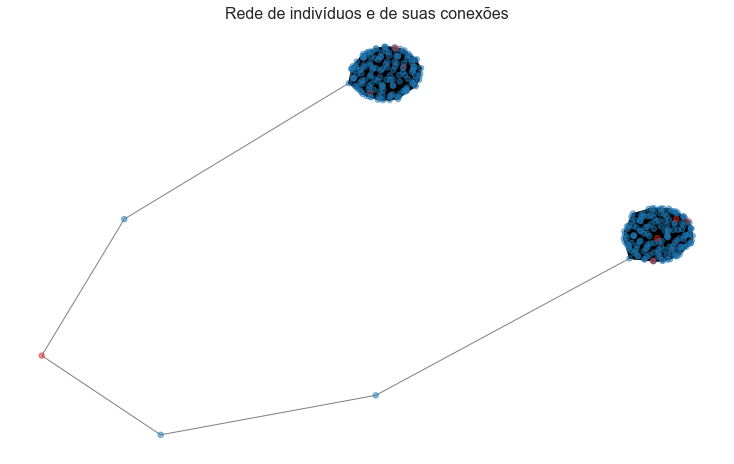

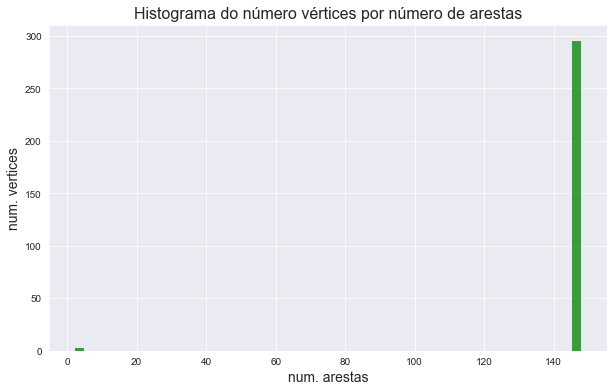

In [27]:
G_b = nx.barbell_graph(int(num_pop/2)-2, 4)
nx.set_node_attributes(G_b, attr_pop_0)
num_medio_conexoes_b = analise_grafo(G_b, info=True, node_size=30, pos=None, hist=True)

### Simulação

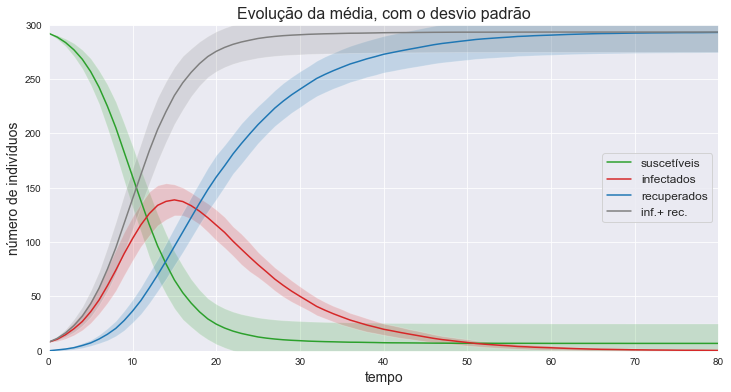

In [28]:
X_b = evolucao_grafo_estruturado(pop_0, beta/num_medio_conexoes_b, gamma, G_b, tempos,
                                 num_sim, show='sd')

### Comparação com o SIR Compartimental e grafos anteriores

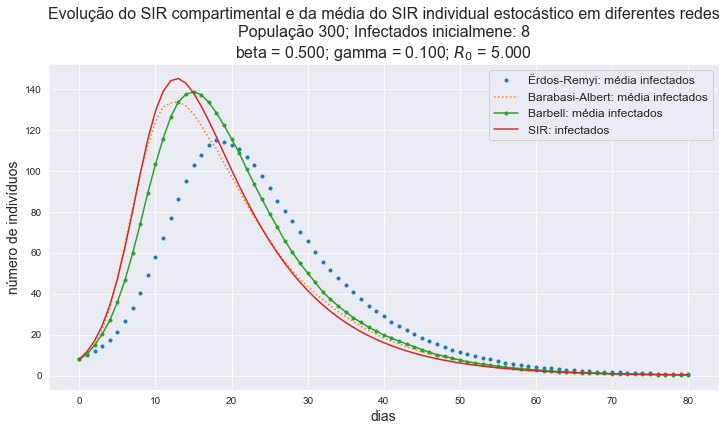

In [29]:
plt.figure(figsize=(12,6))
#plt.ylim(0, num_pop/2)

# exibe os gráficos das médias
plt.plot(tempos, X_er.I_media, '.', label='Ërdos-Remyi: média infectados')
plt.plot(tempos, X_ba.I_media, ':', label='Barabasi-Albert: média infectados')
plt.plot(tempos, X_b.I_media, '.-', label='Barbell: média infectados')
plt.plot(tempos, X.I, 'tab:red', label='SIR: infectados')

# informações para o gráfico
plt.xlabel('dias', fontsize=14)
plt.ylabel('número de indivíduos', fontsize=14)
plt.title('Evolução do SIR compartimental e da média do SIR individual estocástico em diferentes redes\n'
          + f'População {num_pop}; Infectados inicialmene: {I_0}\n'
          + f'beta = {beta:.3f}; gamma = {gamma:.3f}; $R_0$ = {beta/gamma:.3f}', fontsize=16)
plt.legend(loc='best', fontsize=12)
plt.show() 

## Simulação com um grafo geométrico

- Vamos considerar, agora, um **grafo geométrico aleatório** construído via função [random_geometric_graph](https://networkx.github.io/documentation/stable/reference/generated/networkx.generators.geometric.random_geometric_graph.html) (veja, também, o seguinte [exemplo](https://networkx.github.io/documentation/stable/auto_examples/drawing/plot_random_geometric_graph.html)).

Número de arestas: 1401
Número de vértices: 300
Número médio de conexões por indivíduo: 9.3


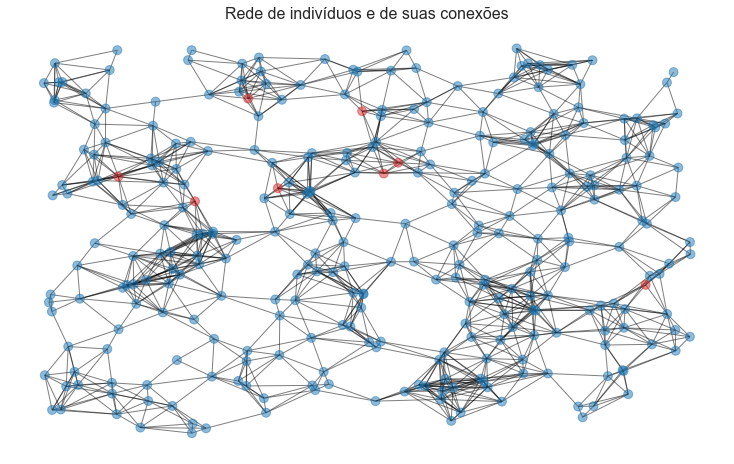

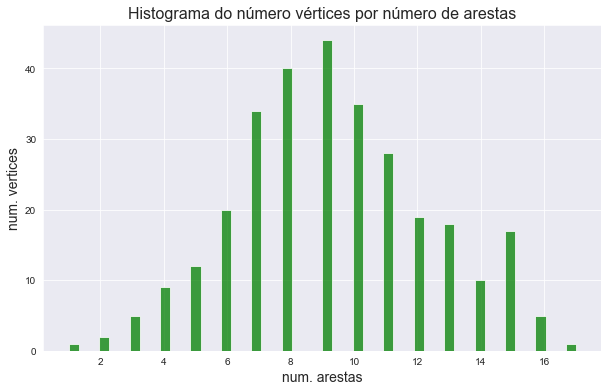

In [30]:
G_g = nx.random_geometric_graph(num_pop, 0.105, seed=2024)
nx.set_node_attributes(G_g, attr_pop_0)
pos_g = nx.get_node_attributes(G_g, "pos")
num_medio_conexoes_g = analise_grafo(G_g, info=True, node_size=80, pos=pos_g, hist=True)

### Simulação

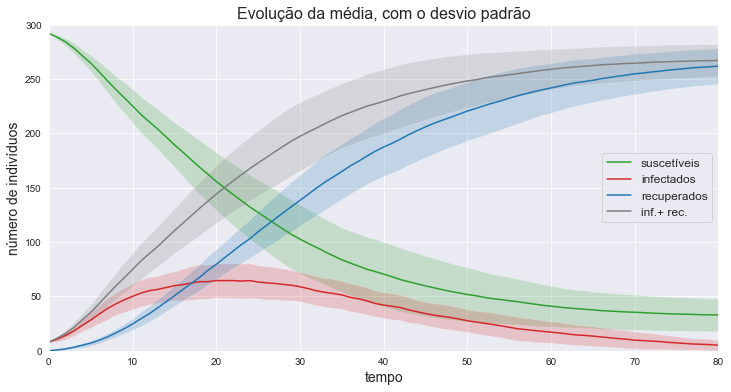

In [31]:
X_g = evolucao_grafo_estruturado(pop_0, beta/num_medio_conexoes_g, gamma, G_g, tempos,
                                 num_sim, show='sd')

### Comparação com o SIR Compartimental e os grafos anteriores

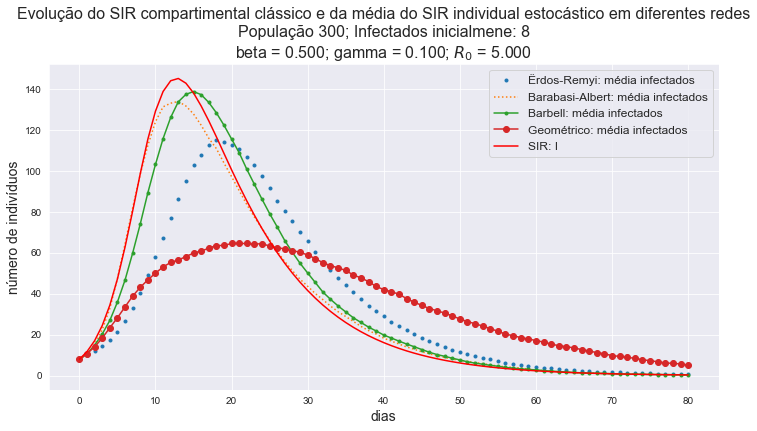

In [32]:
plt.figure(figsize=(12,6))
#plt.ylim(0, num_pop/2)

# exibe os gráficos das médias
plt.plot(tempos, X_er.I_media, '.', label='Ërdos-Remyi: média infectados')
plt.plot(tempos, X_ba.I_media, ':', label='Barabasi-Albert: média infectados')
plt.plot(tempos, X_b.I_media, '.-', label='Barbell: média infectados')
plt.plot(tempos, X_g.I_media, 'o-', label='Geométrico: média infectados')
plt.plot(tempos, X.I, 'red', label='SIR: I')

# informações para o gráfico
plt.xlabel('dias', fontsize=14)
plt.ylabel('número de indivíduos', fontsize=14)
plt.title('Evolução do SIR compartimental clássico e da média do SIR individual estocástico em diferentes redes\n'
          + f'População {num_pop}; Infectados inicialmene: {I_0}\n'
          + f'beta = {beta:.3f}; gamma = {gamma:.3f}; $R_0$ = {beta/gamma:.3f}', fontsize=16)
plt.legend(loc='best', fontsize=12)
plt.show() 

## A fazer

- Separar as conexões fixas de acordo com o tipo (núcleo familiar, trabalho/escola, local, etc.)

- Incluir pesos para as conexões fixas.

- Simular o efeito de fechamento de estabelecimentos, distanciamento social e métodos de prevenção nos parâmetros ligados a cada tipo de conexão.

- Obter um grafo mais realista para a cidade do Rio de Janeiro.

## Trabalho 7

**Questões:**

1. Seguindo a ideia de um dos exercícios do trabalho anterior, analise qual das redes é mais sensível à diminuição do número de infectados.

1. Na Figura 1.2, do livro [Kiss, Miller & Simon (2017)](#Referências), vemos a frase *"The simulations begin with 1% infected, and t = 0 is set when prevalence reaches 2.5% in order to reduce stochastic noise in the average."*. Pense em como implementar isso, no nosso modelo individual.

1. Faça uma busca por outros tipos de redes que sejam interessantes de considerar para esse modelo/projeto.

1. Para cada uma das redes, tente fazer um ajuste dos parâmetros aos dados de epidemia de influenza discutidos no caderno da Aula 2 de "Ajustes de parâmetros".

**Observação:** Pode usar uma população menor, como 100 habitantes, assim como um número menor de simulações, para que os cálculos sejam mais rápidos

**Observação:** Escolha parâmetros que exibam epidemia.

# Referências

- [Imperial College COVID-19 Response Team (16/mar/2020), Impact of non-pharmaceutical interventions (NPIs) to reduce COVID- 19 mortality and healthcare demand, 16 de março de 2020. (Free Download)](https://www.imperial.ac.uk/media/imperial-college/medicine/sph/ide/gida-fellowships/Imperial-College-COVID19-NPI-modelling-16-03-2020.pdf)

- [Ferguson NM, Cummings DAT, Fraser C, Cajka JC, Cooley PC, Burke DS (2006). Strategies for mitigating an influenza pandemic. Nature 442 (7101), 448–52 (Free Download)](https://pubmed.ncbi.nlm.nih.gov/16642006/); veja, também, as [notas suplementares](https://www.nature.com/articles/nature04795#Sec2).

- [Ferguson, N. M. et al. (2005), Strategies for containing an emerging influenza pandemic
in Southeast Asia, Nature 437, 209-214.](https://pubmed.ncbi.nlm.nih.gov/16079797/) (Link para download [aqui](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.452.235&rep=rep1&type=pdf) disponibilizado por [CiteSeerX](http://citeseerx.ist.psu.edu/); veja, também, as [notas suplementares](https://static-content.springer.com/esm/art%3A10.1038%2Fnature04017/MediaObjects/41586_2005_BFnature04017_MOESM1_ESM.pdf).

- [Halloran ME, Ferguson NM, Eubank S, et al (2008), Modeling targeted layered containment of an influenza pandemic in the United States. Proc Natl Acad Sci U S A 105 (12), 4639–44 (Free Download).](https://pubmed.ncbi.nlm.nih.gov/18332436/); veja, também, o [suplemento do artigo](https://www.pnas.org/content/suppl/2008/02/28/0706849105.DC1).

- [M. J. Keeling & P. Rohani (2007), Modeling Infectious Diseases in Humans and Animals, Princeton University Press.](https://press.princeton.edu/books/hardcover/9780691116174/modeling-infectious-diseases-in-humans-and-animals)

- [I. Z. Kiss, J. Miller & P. L. Simon (2017), Mathematics of Epidemics on Networks: From Exact to Approximate Models, Springer-Verlag.](https://www.springer.com/br/book/9783319508047)

Veja a página [Imperial College - Covid 19](https://www.imperial.ac.uk/mrc-global-infectious-disease-analysis/covid-19/) para mais relatórios, publicações e outras informações do Imperial College.

<!--NAVIGATOR-->

---
[<- Modelos baseados em indivíduos e o relatório do Imperial Colege](06.00.Aula-Modelos_baseados_em_individuos.ipynb) | [Página Inicial](00.00-Pagina_Inicial.ipynb) | [Modelos individuais estocásticos com múltiplas estruturas de conexão - parte I ->](08.00.Aula-Modelos_individuais_multiplas_estruturas.ipynb)